In [1]:
# import easyocr
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from deskew import determine_skew
from skimage.transform import rotate
import os

from pdf2image import convert_from_path
# from img2table.ocr import EasyOCR
# from img2table.document import Image

In [2]:
# preprocess image
def preprocess_image(image):
    preprocess_image = image.copy()
    return preprocess_image

#load reader
# def load_reader(lang):
    # reader = easyocr.Reader([lang])
    # return reader

# extract text using ocr
def extract_text(image, reader):
    result = reader.readtext(image)
    return result


In [3]:
import os
import cv2
# import matplotlib.pyplot as plt
from paddleocr import PPStructure,draw_structure_result,save_structure_res
from PIL import Image
import matplotlib.font_manager as fm

In [56]:
path = 'Sample/IOL.png'
img = cv2.imread(path)
# gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# resize image
gray = cv2.resize(gray, (1000, 1500), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# crop
sample = gray[600:795, 80:520]
# sample = gray[600:650, 80:240]
# save image
# cv2.imwrite('Sample/sample.png', sample)
# plt.figure(figsize=(50, 50))
# plt.imshow(sample)

In [83]:
table_engine = PPStructure()

[2023/11/30 15:34:59] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\earth/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\earth/.paddleocr/whl\\rec\\ch\\ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_leng

In [84]:
path = 'Sample/IOL.png'
img = cv2.imread(path)
img = cv2.resize(img, (1000, 1500), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
img = img[600:795, 80:520]

In [87]:
save_folder = 'Sample'
path = 'sample.png'
font_path = fm.findfont(fm.FontProperties(family='Arial'))

# img = cv2.imread(os.path.join(save_folder, path))
result = table_engine(img)
save_structure_res(result, save_folder,os.path.basename(path).split('.')[0])
for line in result:
    line.pop('img')
    print(line)

[2023/11/30 15:35:22] ppocr DEBUG: dt_boxes num : 27, elapsed : 0.06694865226745605
[2023/11/30 15:35:22] ppocr DEBUG: rec_res num  : 27, elapsed : 0.091949462890625
{'type': 'figure', 'bbox': [0, 0, 440, 194], 'res': [{'text': 'Biometric', 'confidence': 0.9053527116775513, 'text_region': [[385.0, 4.0], [439.0, 4.0], [439.0, 21.0], [385.0, 21.0]]}, {'text': 'AL: 23.80 mm', 'confidence': 0.9534253478050232, 'text_region': [[28.0, 25.0], [131.0, 25.0], [131.0, 42.0], [28.0, 42.0]]}, {'text': 'SD:', 'confidence': 0.9653353691101074, 'text_region': [[195.0, 26.0], [221.0, 26.0], [221.0, 42.0], [195.0, 42.0]]}, {'text': '8um', 'confidence': 0.8844614028930664, 'text_region': [[250.0, 23.0], [293.0, 26.0], [292.0, 45.0], [249.0, 42.0]]}, {'text': 'ACD:2.57mm', 'confidence': 0.9907262921333313, 'text_region': [[14.0, 44.0], [131.0, 44.0], [131.0, 65.0], [14.0, 65.0]]}, {'text': 'SD:', 'confidence': 0.9725955128669739, 'text_region': [[194.0, 43.0], [223.0, 43.0], [223.0, 64.0], [194.0, 64.0]]

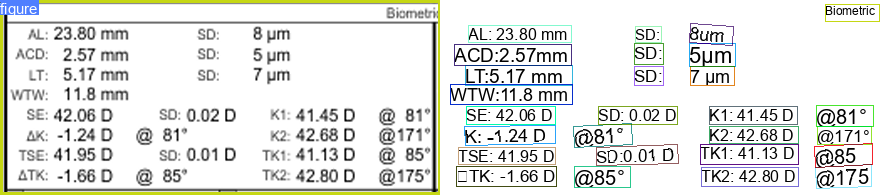

In [88]:
im_show = draw_structure_result(img, result, font_path=font_path)
im_show = Image.fromarray(im_show)
im_show

In [89]:
import os
import cv2
from paddleocr import PPStructure,save_structure_res
from paddleocr.ppstructure.recovery.recovery_to_doc import sorted_layout_boxes, convert_info_docx

In [90]:
# English image
table_engine = PPStructure(recovery=True, lang='en')

result = table_engine(img)
save_structure_res(result, save_folder, os.path.basename(path).split('.')[0])

for line in result:
    line.pop('img')
    print(line)

h, w, _ = img.shape
res = sorted_layout_boxes(result, w)
convert_info_docx(img, res, save_folder, os.path.basename(path).split('.')[0])

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to C:\Users\earth/.paddleocr/whl\det\en\en_PP-OCRv3_det_infer\en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:07<00:00, 540kiB/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to C:\Users\earth/.paddleocr/whl\rec\en\en_PP-OCRv4_rec_infer\en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:22<00:00, 451kiB/s] 


download https://paddleocr.bj.bcebos.com/ppstructure/models/slanet/en_ppstructure_mobile_v2.0_SLANet_infer.tar to C:\Users\earth/.paddleocr/whl\table\en_ppstructure_mobile_v2.0_SLANet_infer\en_ppstructure_mobile_v2.0_SLANet_infer.tar


100%|██████████| 10.2M/10.2M [00:20<00:00, 494kiB/s] 


download https://paddleocr.bj.bcebos.com/ppstructure/models/layout/picodet_lcnet_x1_0_fgd_layout_infer.tar to C:\Users\earth/.paddleocr/whl\layout\picodet_lcnet_x1_0_fgd_layout_infer\picodet_lcnet_x1_0_fgd_layout_infer.tar


100%|██████████| 10.1M/10.1M [00:18<00:00, 547kiB/s] 

[2023/11/30 15:46:04] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\earth/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\earth/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_leng

[2023/11/30 15:46:15] ppocr DEBUG: dt_boxes num : 29, elapse : 0.0646665096282959
[2023/11/30 15:46:15] ppocr DEBUG: rec_res num  : 29, elapse : 0.07897257804870605
{'type': 'table', 'bbox': [3, 0, 438, 194], 'res': {'cell_bbox': [[74.07674407958984, 9.417580604553223, 143.23326110839844, 24.038795471191406], [366.26031494140625, 4.710771083831787, 428.4359436035156, 25.716249465942383], [22.37406349182129, 27.909311294555664, 110.48455810546875, 45.78326416015625], [233.63441467285156, 27.69993782043457, 281.4725341796875, 46.439144134521484], [379.1569519042969, 31.97170639038086, 416.1826477050781, 49.08456039428711], [29.231521606445312, 46.65876388549805, 121.38326263427734, 66.55261993408203], [229.68746948242188, 46.88441467285156, 278.592529296875, 66.5306167602539], [361.53118896484375, 49.053314208984375, 401.641357421875, 67.13859558105469], [33.36315155029297, 65.89144897460938, 119.79817962646484, 86.28236389160156], [238.14125061035156, 65.7689208984375, 284.2738037109375